In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import random


In [37]:

def get_default_device():
    '''Pick gpu if available else pick cpu'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to choosen device'''
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    return data.to(device, non_blocking=True)

device = get_default_device()

eeg_data = pd.read_csv(r"C:\Users\Klaes\Desktop\emotions.csv.zip")
print(eeg_data.head())

eeg_data['label'] = eeg_data['label'].replace(['NEUTRAL', 'NEGATIVE', 'POSITIVE'],['CALM', 'DISTRACTED', 'CONCENTRATED'])
eeg_data_copy = eeg_data.copy()
eeg_data['label'] = eeg_data['label'].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(eeg_data.drop('label', axis=1), eeg_data['label'], random_state=42, test_size=0.2, stratify=eeg_data['label'])

# convert test to numpy
y_test = y_test.to_numpy()
# convert to numpy arrays
inputs_array = X_train.to_numpy()
targets_array = y_train.to_numpy()

# convert to tensors
inputs = to_device(torch.FloatTensor(inputs_array),device)
targets = to_device(torch.FloatTensor(targets_array), device)

# define batch size
batch_size = 128

class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_size).float()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, h = self.lstm(x)
        out = self.fc(self.relu(out))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden

input_size = len(X_train.columns)
output_size = len(y_train.unique())
hidden_dim = 128
n_layers = 2
# init hyperparameters
n_epochs = 430
# init model
LSTMmodel = LSTMModel(input_size, output_size, hidden_dim, n_layers)

to_device(LSTMmodel, device)

#Training the LSTM Model
#define loss and optimizer
losses = []
l_rates = [1e-1, 1e-2, 1e-3, 1e-4]
l_r_i = 2
criterion = nn.CrossEntropyLoss()
losses = []
optimizer = torch.optim.Adam(LSTMmodel.parameters(), l_rates[l_r_i])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() 
    output, hidden = LSTMmodel(inputs.unsqueeze(0))
    loss = criterion(output.squeeze(0).float(), targets.long())
    loss_detached = loss.detach().cpu().clone().numpy()
    losses.append(loss_detached)

    loss.backward() 
    optimizer.step()

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))


   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  ff

C:\Users\Klaes\AppData\Local\Temp\ipykernel_17792\907151966.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predictions = np.array(torch.argmax(output_, 1, keepdim=True))


<Axes: >

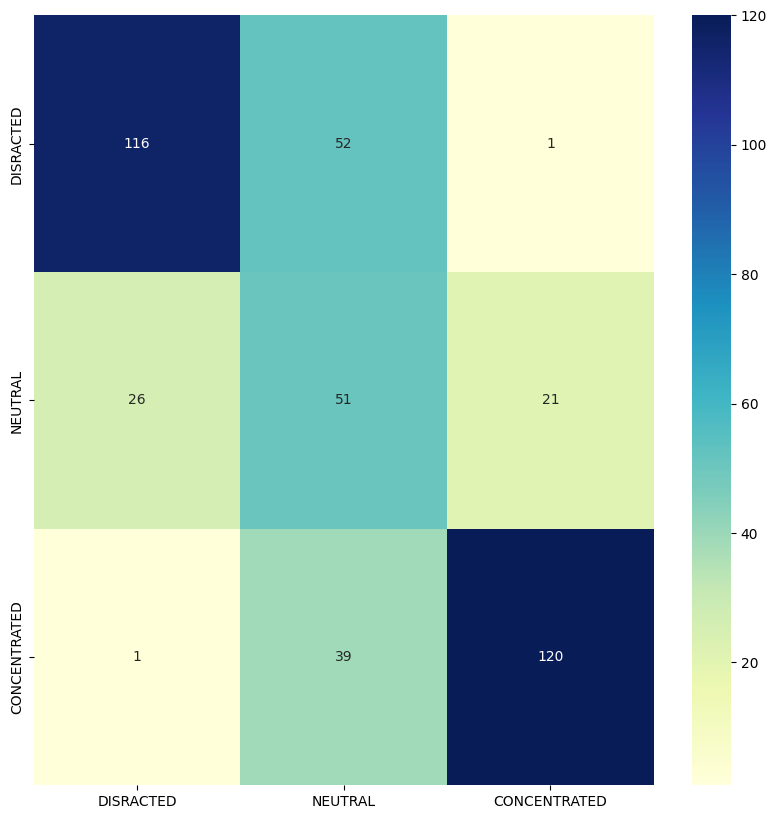

In [42]:
test_data = to_device(torch.FloatTensor(X_test.to_numpy()).unsqueeze(0), device)
output = LSTMmodel(test_data)[0]

torch.save(LSTMmodel.state_dict(), r"C:\Users\Klaes\Desktop\lstm_model.pth")
mood_list = ['DISRACTED', 'NEUTRAL', 'CONCENTRATED']
output = output.squeeze(0)
output_ = output.detach().cpu().clone()
predictions = np.array(torch.argmax(output_, 1, keepdim=True))

c_m = confusion_matrix(predictions, y_test)

plt.figure(figsize=(10, 10))
sbn.heatmap(c_m, annot=True, cmap='YlGnBu', fmt='g', yticklabels=mood_list, xticklabels=mood_list)

In [7]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       143
           1       0.43      0.35      0.39       142
           2       0.73      0.84      0.78       142

    accuracy                           0.62       427
   macro avg       0.60      0.62      0.61       427
weighted avg       0.60      0.62      0.61       427



In [23]:
import socket
import pandas as pd
from io import StringIO
import time

def main():
    print("Unicorn Recorder UDP Receiver Example")
    print("----------------------------")
    print()

    try:
        # Define an IP endpoint
        port = 1001
        ip = "0.0.0.0"  # Equivalent to IPAddress.Any
        print(f"Listening on port '{port}'...")

        # Initialize UDP socket
        with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as sock:
            sock.bind((ip, port))
            
            # Initialize a list to hold incoming data
            data_list = []

            # Acquisition loop
            while True:
                data, addr = sock.recvfrom(1024)
                if data:
                    # Decode the incoming data and append to the list
                    line_data = data.decode('ascii').strip()
                    data_list.append(line_data)

                    # Convert the list to a DataFrame once enough data has been collected
                    if len(data_list) >= 10:  # Adjust the number as needed
                        # Join the lines into a single string
                        data_string = "\n".join(data_list)

                        # Create a DataFrame from the string data
                        df = pd.read_csv(StringIO(data_string), header=None)

                        # Set column names
                        df.columns = [f'mean_{i}_a' for i in range(len(df.columns))]

                        # Print the DataFrame
                        print(df)

                        time.sleep(3)

                        # Clear the list for the next batch of data
                        data_list = []

    except Exception as ex:
        print(f"Error: {ex}")
        input("Press ENTER to terminate the application.")

if __name__ == "__main__":
    main()


Unicorn Recorder UDP Receiver Example
----------------------------

Listening on port '1001'...
   mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_5_a  mean_6_a  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
6       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
7       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
8       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
9       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   mean_7_a  mean_8_a  
0       0.0       0.0  
1       0.0       0.0  
2     

KeyboardInterrupt: 

In [27]:
input_size = len(X_train.columns)
output_size = len(y_train.unique())
hidden_dim = 128
n_layers = 2
print(input_size)
print(output_size)

2548
3
